In [2]:
import scanpy as sc
import scrublet as scr
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import gseapy as gp
from scipy.sparse import csc_matrix
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('../data/BRCA_GSE161529_expression_skc_doublet_onehotencoded.h5ad')

In [9]:
sum(adata.var_names.str.startswith('MT-'))

np.int64(13)

In [10]:
# Calcualte the mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata.obs['pct_counts_mt'].describe()

count    332168.000000
mean          1.779275
std           0.753999
min           0.000000
25%           1.302427
50%           1.634993
75%           2.087639
max          19.919041
Name: pct_counts_mt, dtype: float64

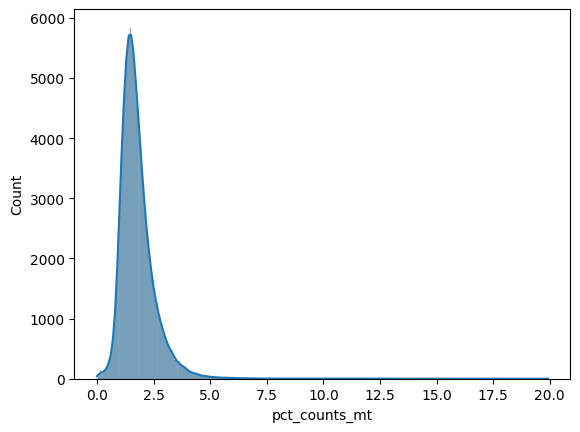

In [12]:
sns.histplot(data=adata.obs, x='pct_counts_mt', kde=True)
plt.show()

In [14]:
adata.obs['mito_pct_group'] = pd.qcut(
    adata.obs['pct_counts_mt'],
    q=5,
    labels=['low', 'mid-low', 'mid', 'mid-high', 'high'],
)

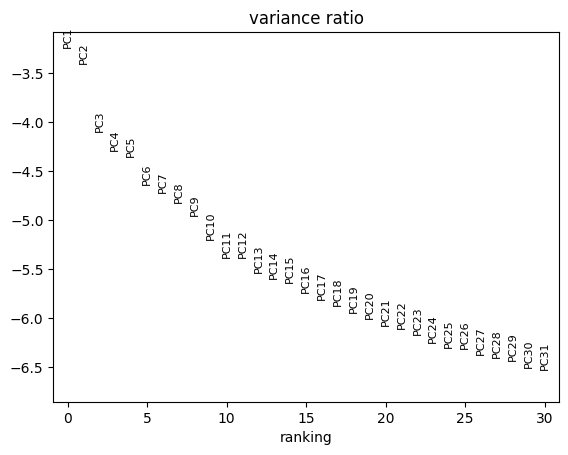

In [15]:
# 1. Compute PCA if not already done
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

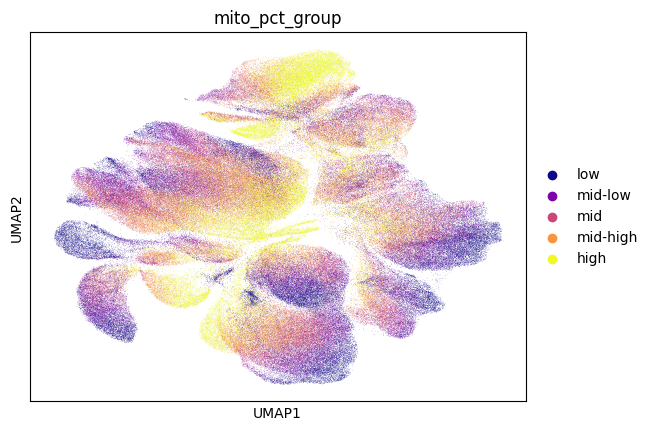

In [16]:
# 2. Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)

# 3. Run UMAP
sc.tl.umap(adata)

# 4. plot
sc.pl.umap(adata, color='mito_pct_group', palette='plasma')

In [37]:
adata.obs['mito_filtered'] = 'keep'
adata.obs.loc[adata.obs['pct_counts_mt'] < 0.25, 'mito_filtered'] = 'drop'

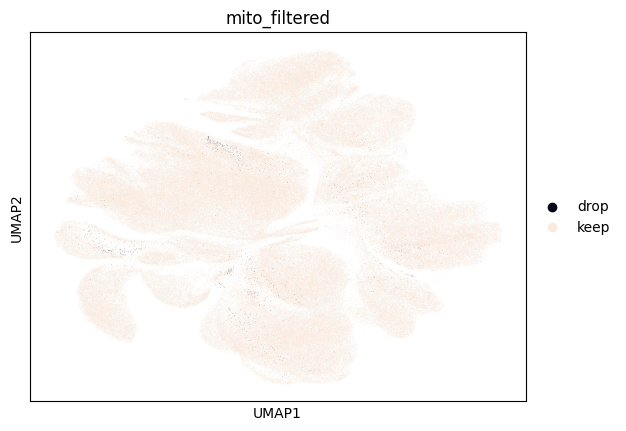

In [38]:
sc.pl.umap(adata, color='mito_filtered', palette='rocket')

In [39]:
onehot_cols = [col for col in adata.obs.columns if col.startswith('TS_')]
onehot_df = adata.obs[onehot_cols]
decoded_labels = onehot_df.idxmax(axis=1)
decoded_labels = decoded_labels.str.replace('TS_', '')
adata.obs['tumor_subtype'] = decoded_labels.astype('category')

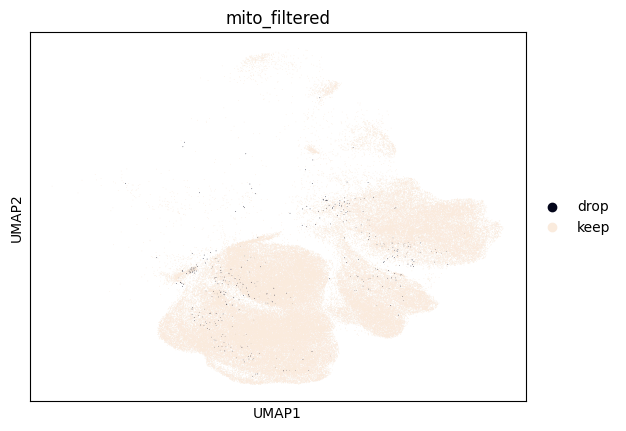

In [40]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Normal'], color=['mito_filtered'])

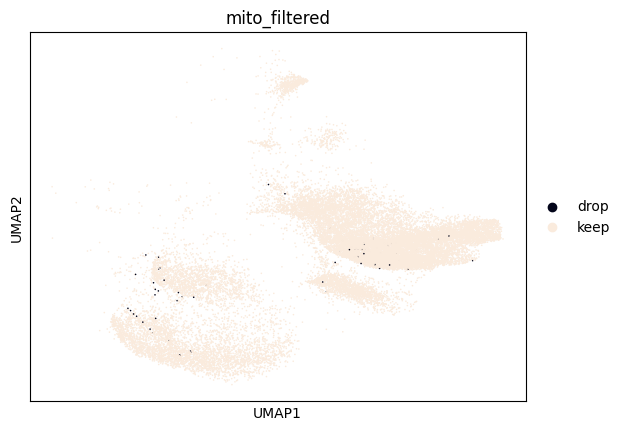

In [41]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'BRCA1 pre-neoplastic'], color=['mito_filtered'])

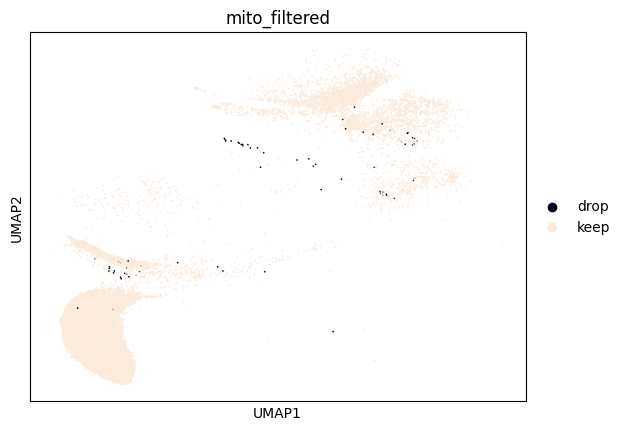

In [42]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative tumour'], color=['mito_filtered'])

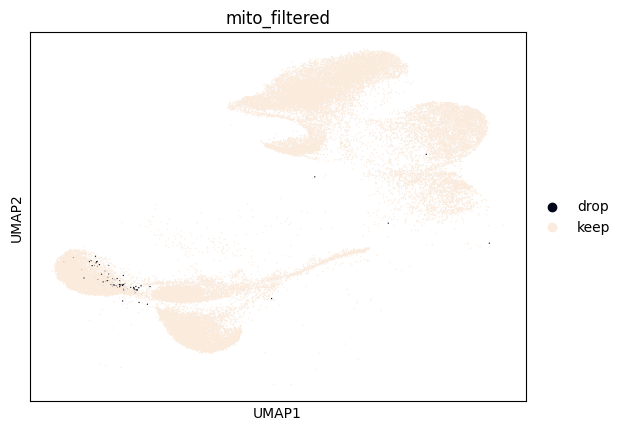

In [43]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative BRCA1 tumour'], color=['mito_filtered'])

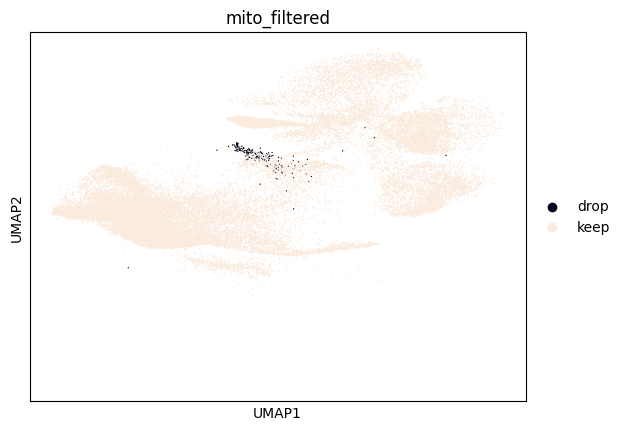

In [44]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'HER2+ tumour'], color=['mito_filtered'])

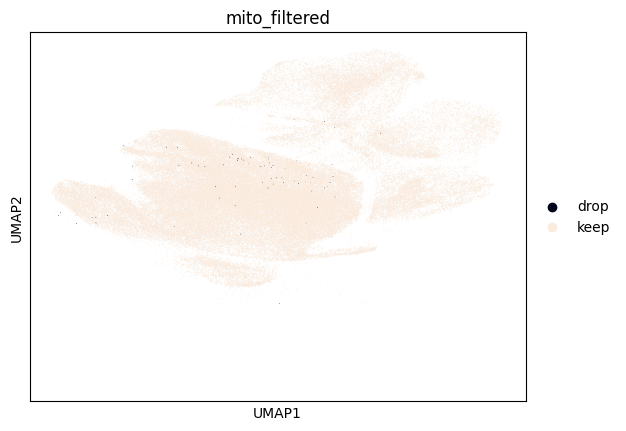

In [45]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'ER+ tumour'], color=['mito_filtered'])

In [46]:
for ts in list(adata.obs['tumor_subtype'].unique()):
    dropped = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['mito_filtered']=='drop')]
    kept = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['mito_filtered']!='drop')]
    total = len(dropped)+len(kept)
    print(f"{ts} ({total}): {len(dropped)/total} - {len(kept)/total}")

Normal (109282): 0.003797514686773668 - 0.9962024853132263
BRCA1 pre-neoplastic (23212): 0.0033172496984318458 - 0.9966827503015682
Triple negative tumour (20377): 0.0037787701820680177 - 0.9962212298179319
Triple negative BRCA1 tumour (34659): 0.0025678755878703946 - 0.9974321244121296
HER2+ tumour (31838): 0.006344619636911866 - 0.9936553803630881
PR+ tumour (2896): 0.02244475138121547 - 0.9775552486187845
ER+ tumour (109904): 0.0007097102926190129 - 0.999290289707381


In [48]:
adata.obs['rna_content_group'] = pd.qcut(
    adata.obs['total_counts'],
    q=5,
    labels=['low', 'mid-low', 'mid', 'mid-high', 'high'],
)

In [53]:
adata.obs['total_counts'].describe()

count    332168.000000
mean       2278.477783
std         570.485168
min         383.741547
25%        1830.647919
50%        2284.397461
75%        2692.866333
max        4283.099121
Name: total_counts, dtype: float64

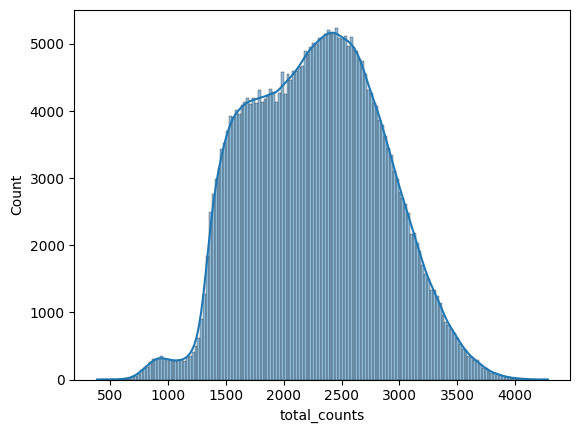

In [54]:
sns.histplot(data=adata.obs, x='total_counts', kde=True)
plt.show()

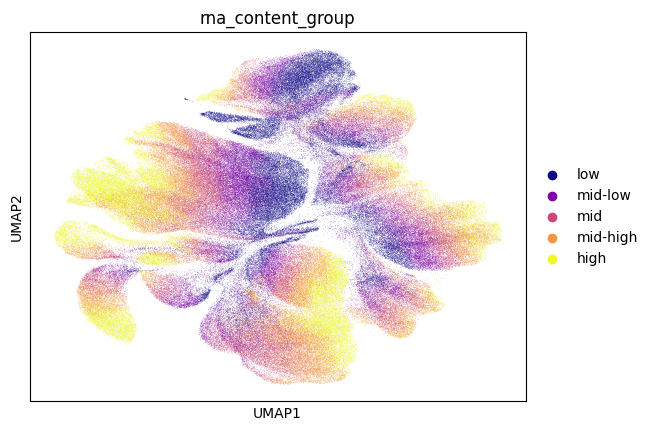

In [49]:
sc.pl.umap(adata, color='rna_content_group', palette='plasma')

In [55]:
adata.obs['rna_filtered'] = 'keep'
adata.obs.loc[adata.obs['total_counts'] < 1250, 'rna_filtered'] = 'drop'

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


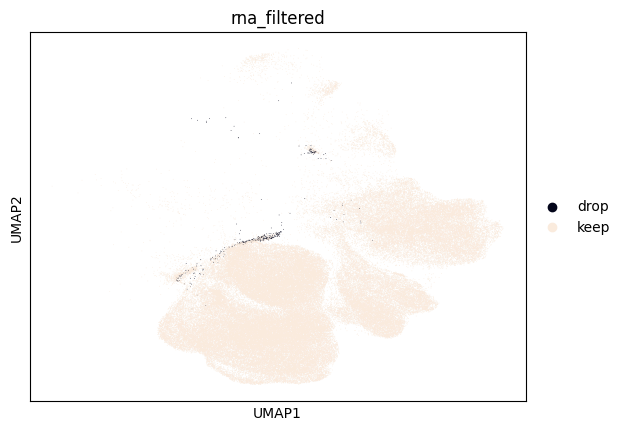

In [57]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Normal'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


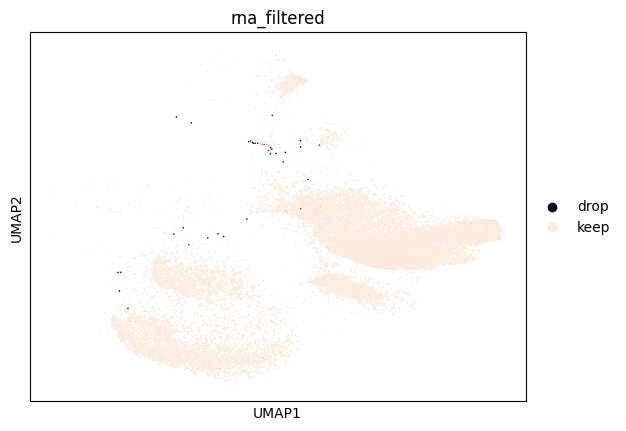

In [58]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'BRCA1 pre-neoplastic'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


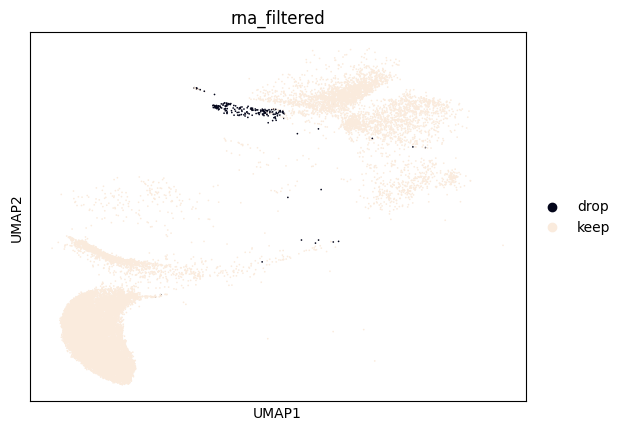

In [59]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative tumour'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


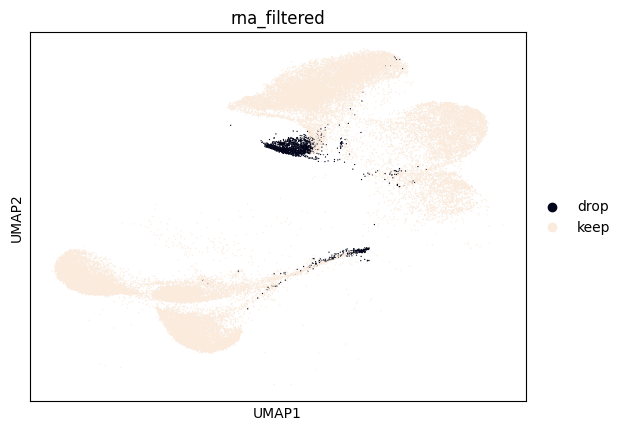

In [60]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative BRCA1 tumour'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


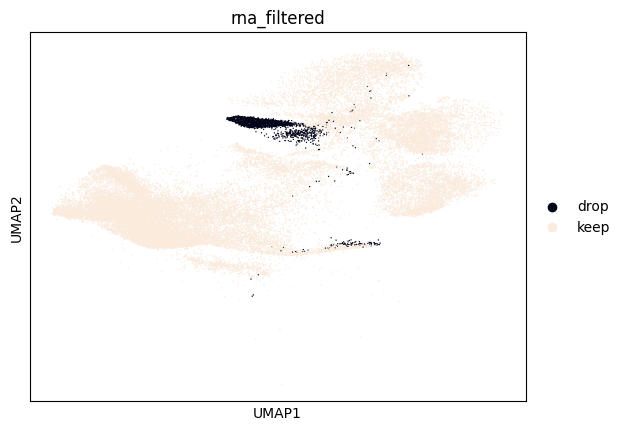

In [61]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'HER2+ tumour'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


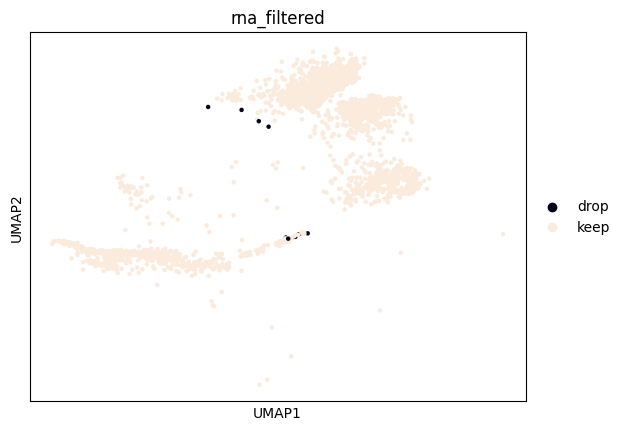

In [62]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'PR+ tumour'], color=['rna_filtered'], palette='rocket')

C:\Users\silly\GitHub\signals-in-the-noise\venv\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


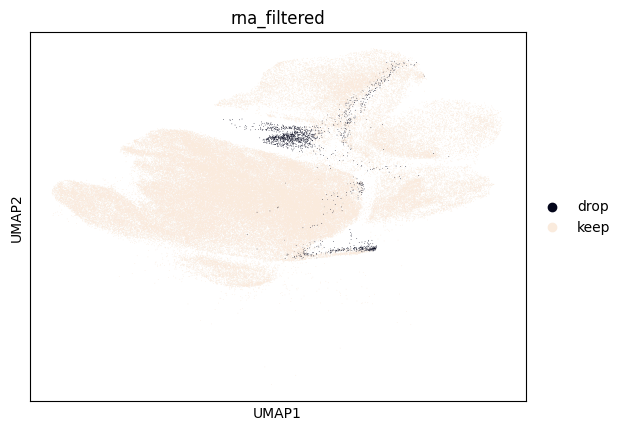

In [63]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'ER+ tumour'], color=['rna_filtered'], palette='rocket')

In [64]:
for ts in list(adata.obs['tumor_subtype'].unique()):
    dropped = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['rna_filtered']=='drop')]
    kept = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['rna_filtered']!='drop')]
    total = len(dropped)+len(kept)
    print(f"{ts} ({total}): {len(dropped)/total} - {len(kept)/total}")

Normal (109282): 0.0037883640489742134 - 0.9962116359510258
BRCA1 pre-neoplastic (23212): 0.0018094089264173703 - 0.9981905910735827
Triple negative tumour (20377): 0.010502036609903322 - 0.9894979633900967
Triple negative BRCA1 tumour (34659): 0.0498571799532589 - 0.9501428200467411
HER2+ tumour (31838): 0.063226333312394 - 0.936773666687606
PR+ tumour (2896): 0.003798342541436464 - 0.9962016574585635
ER+ tumour (109904): 0.015504440238753822 - 0.9844955597612461


In [65]:
adata_mito_drop = adata[adata.obs['mito_filtered'] == 'drop'].copy()
adata_mito_keep = adata[adata.obs['mito_filtered'] == 'keep'].copy()

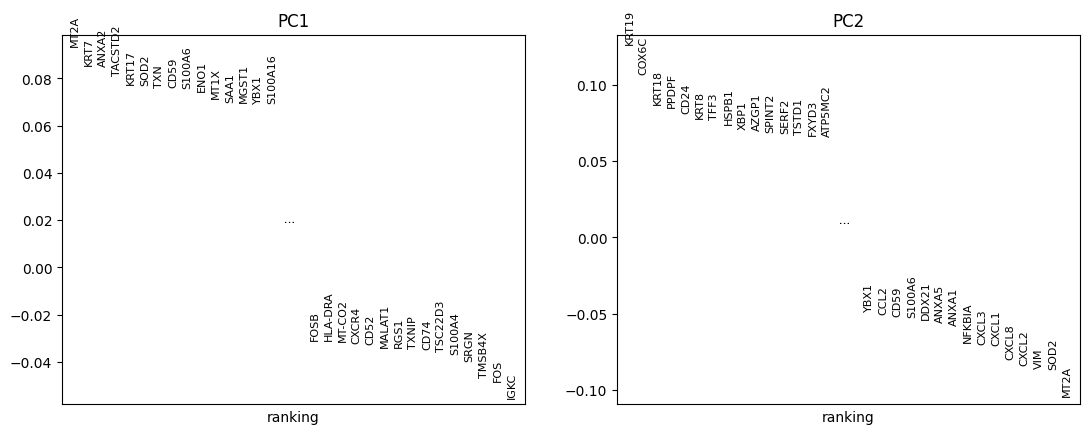

In [66]:
sc.pl.pca_loadings(adata_mito_drop, components=[1,2])

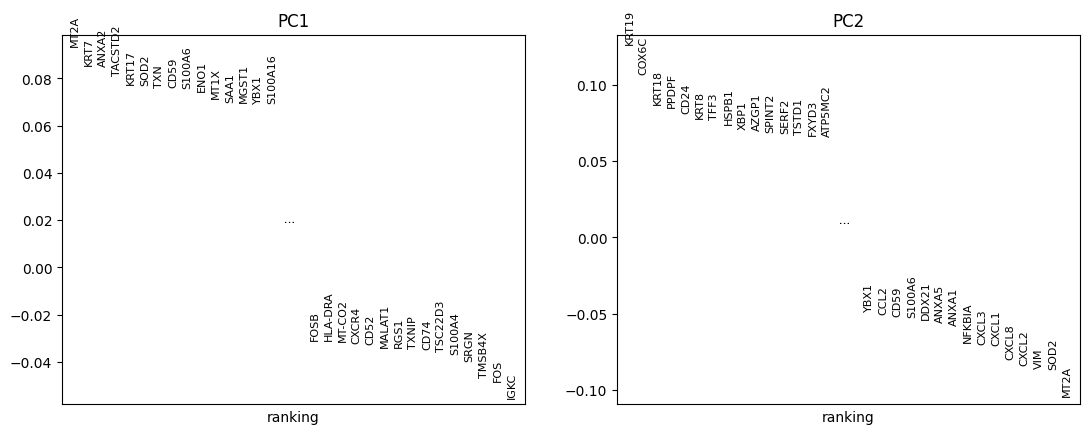

In [67]:
sc.pl.pca_loadings(adata_mito_keep, components=[1,2])

In [68]:
adata_rna_drop = adata[adata.obs['rna_filtered'] == 'drop'].copy()
adata_rna_keep = adata[adata.obs['rna_filtered'] == 'keep'].copy()

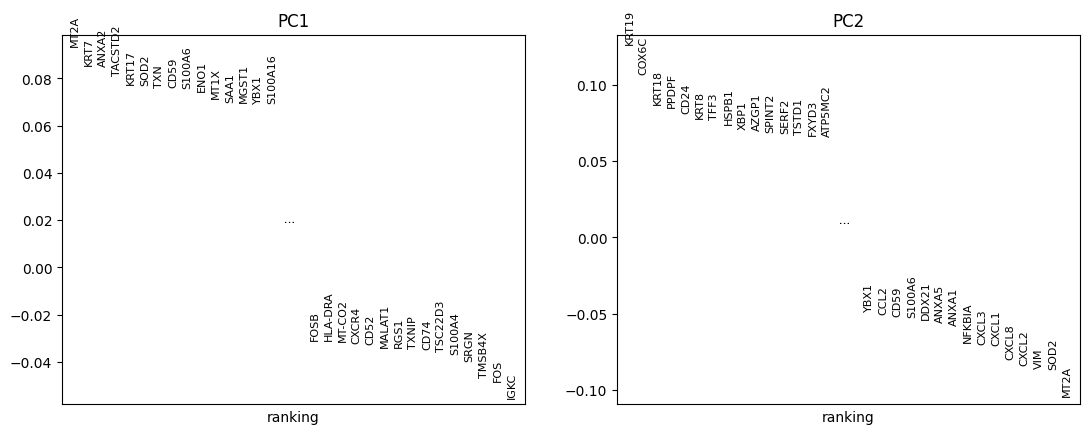

In [69]:
sc.pl.pca_loadings(adata_rna_drop, components=[1,2])

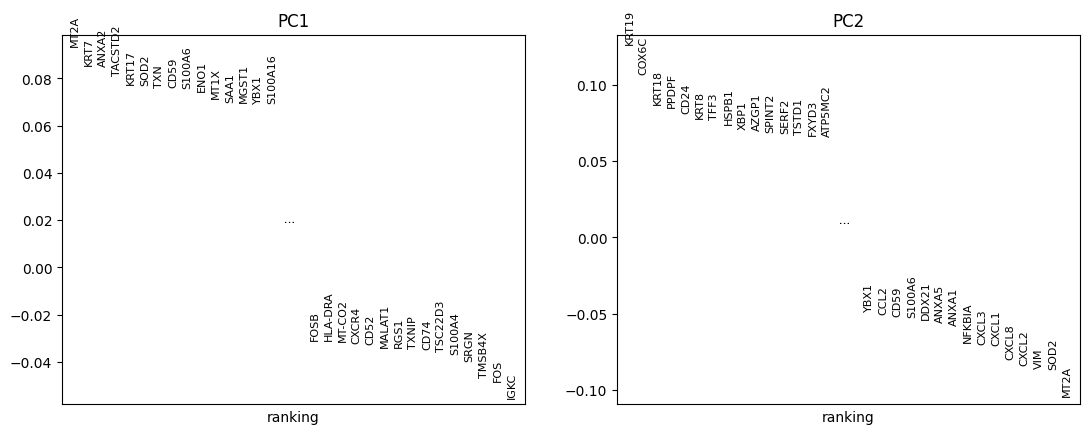

In [70]:
sc.pl.pca_loadings(adata_rna_keep, components=[1,2])